## 1. Load Image

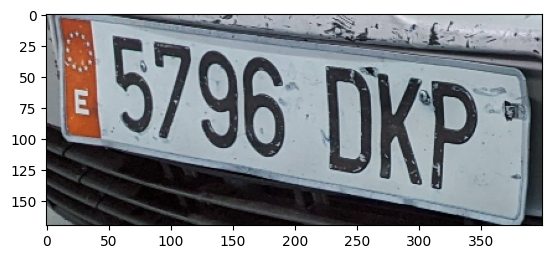

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Cargar imagen desde path
image = cv2.imread('tmp_cropped_2/tmp_cropped_0.jpg')

# Resize mantain aspect ratio
ar1 = image.shape[1] / image.shape[0]
new_width = 400
new_height = int(new_width / ar1)
image = cv2.resize(image, (new_width, new_height))

# Mostar imagen
plt.imshow(image)


## 2. Convert color space

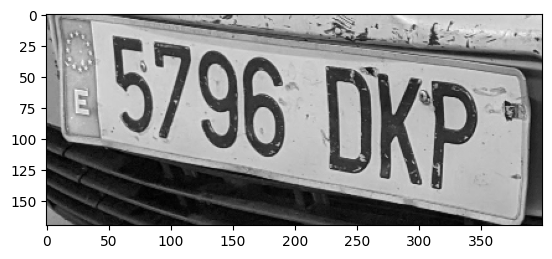

In [20]:
# augmentem contrast per evitar detectar nacionalitat
alpha = 3
beta = 0

# Convertir imagen a espacio HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Show image
plt.imshow(hsv[:,:,2],cmap='gray')
plt.show()

## 3. Binarize using Otsu

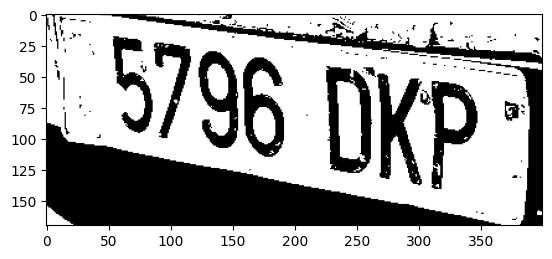

In [21]:
# Obtener el canal de valor (V) del HSV
v_channel = hsv[:,:,2]

# Binarizar la imagen usando el método de Otsu
_, binary_image = cv2.threshold(v_channel, 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Mostrar la imagen binarizada
plt.imshow(binary_image, cmap='gray')




## 4. Find contours

In [22]:
## fun aux

def is_inside(contour1, contour2):
    """ Verifica si contour1 está completamente dentro de contour2 """
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)
    
    return (x1 > x2 and y1 > y2 and (x1 + w1) < (x2 + w2) and (y1 + h1) < (y2 + h2))


In [23]:
## aux fun
def find_contours_mat(binary_image,image = None, w_min = 13, w_max = 79, h_min = 26, h_max = 119):
    # Encontrar contornos en la imagen binarizada
    contours_letters, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Limites Width y Height
    # w_min = 5
    # w_max = 30
    # h_min = 10
    # h_max = 45
    print('limits')
    print('wmin',w_min,'wmax',w_max)
    print('hmin',h_min,'hmax',h_max)

    if image is not None:
        image_cp2 = image.copy()

    filt_contours = []
    # Iterem sobre els contorns trobats
    for contour in contours_letters:
        x, y, w, h = cv2.boundingRect(contour)
        # filtrem per alçada i amplada
        if w_min < w < w_max and h_min < h < h_max:
                filt_contours.append(contour)

                # # DESCOMENTAR PER VEURE CADA STEP
                # cv2.rectangle(image_cp2, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # print(x,y,w,h)
                # plt.imshow(cv2.cvtColor(image_cp2, cv2.COLOR_BGR2RGB))
                # plt.axis('off')  # Opcional: para ocultar los ejes
                # plt.show()


    # Crear una lista de contornos a eliminar
    contours_to_remove = []

    # Crear una lista de contornos a eliminar
    contours_to_remove = set()

    # Eliminar contornos sobrepuestos y duplicados
    for i, cnt in enumerate(filt_contours):
        # Si el índice de cnt ya está marcado para eliminar, se salta
        if i in contours_to_remove:
            continue
        
        for j, cnt2 in enumerate(filt_contours):
            if i != j:
                # Si el índice de cnt2 ya está marcado para eliminar, se salta
                if j in contours_to_remove:
                    continue
                
                b = is_inside(cnt, cnt2)
                x1, y1, w1, h1 = cv2.boundingRect(cnt)
                x2, y2, w2, h2 = cv2.boundingRect(cnt2)

                # Verificar si son iguales o si uno está dentro del otro
                if (x1 == x2 and y1 == y2 and w1 == w2 and h1 == h2) or b:
                    contours_to_remove.add(i)  # Añadir índice de cnt a eliminar
                    break  # No es necesario seguir iterando sobre cnt2

    # Filtrar contornos que no están en contours_to_remove
    filt_contours = [cnt for i, cnt in enumerate(filt_contours) if i not in contours_to_remove]

                

    return filt_contours

Intent 1
limits
wmin 13 wmax 79
hmin 26 hmax 119


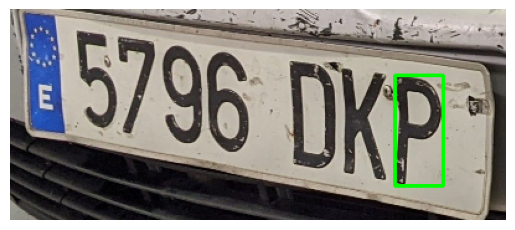

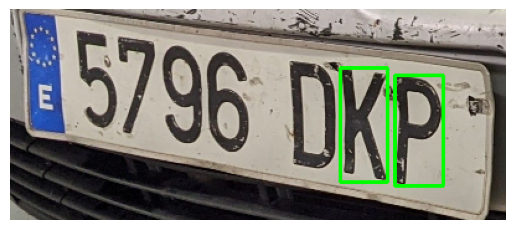

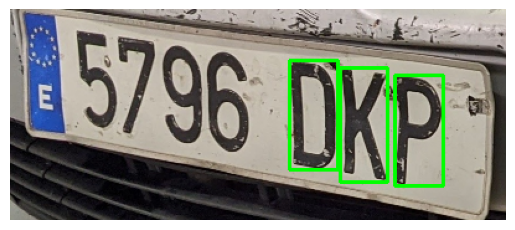

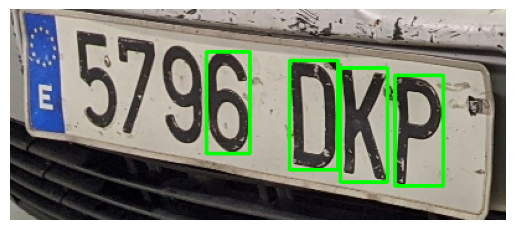

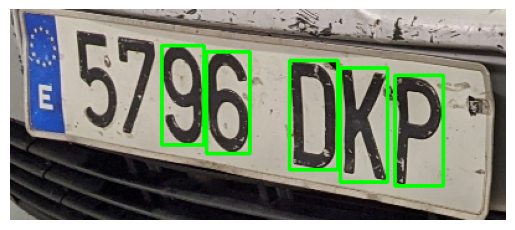

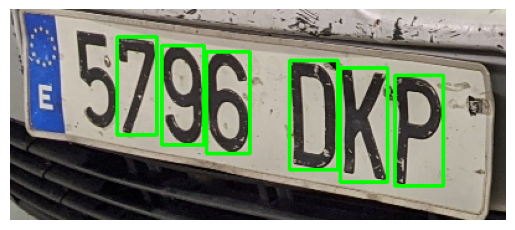

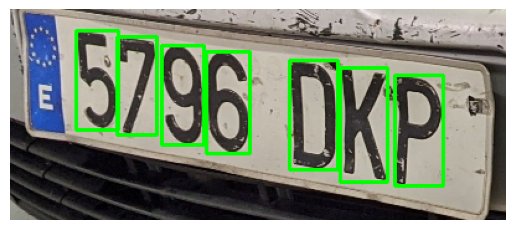

CONTORNS TROBATS 7


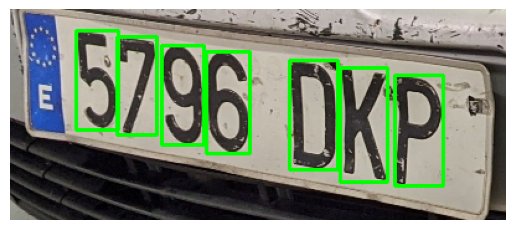

In [24]:
# Copiamos la imagen original para no modificarla
image_cp = image.copy()
image_cp2 = image.copy()



n_intents = 5
for i in range(n_intents):
    
    # 1. Si es el primer intent, fem trobar contorns
    if i == 0:
        print('Intent 1')
        flt_contours = find_contours_mat(binary_image)

    # 2. Si es el 2n intent, fem dilate + erode
    if i == 1:
        print('Intent 2')
        bin_cp = binary_image.copy()
        kernel = np.ones((2, 2), np.uint8)
        bin_cp = cv2.dilate(bin_cp, kernel, iterations=1)
        bin_cp = cv2.erode(bin_cp, kernel, iterations=1)

        # # save to tmp folder
        # cv2.imwrite('tmp/bin_ed1.jpg', bin_cp)

        flt_contours = find_contours_mat(bin_cp)

    # 3. Si es el 3r intent, fem canny edge
    if i == 2:
        bin_cp = binary_image.copy()
        print('Intent 3')
        # # Convertir imagen a escala de grises
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Aplicar un filtro de mediana para eliminar ruido
        gray = cv2.medianBlur(bin_cp, 3)

        # Aplicar el detector de bordes Canny
        edges = cv2.Canny(gray, 50, 150)

        # Encontrar contornos en la imagen binarizada
        flt_contours = find_contours_mat(edges)

    # 4. Si es el 6è intent, augmentem contrast per evitar detectar la nacionaalitat
    if i == 3:
        img_cp = image.copy()
        print('Intent 4')

        # augmentar contrast
        img_contr = cv2.convertScaleAbs(img_cp, alpha=3, beta=0)

        # Obtenim v de hsv i binaritzem
        hsv = cv2.cvtColor(img_contr, cv2.COLOR_BGR2HSV)
        v_channel = hsv[:, :, 2]
        _, bin_cp = cv2.threshold(v_channel, 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        flt_contours = find_contours_mat(bin_cp)

    # 5. Si es el 4t intent, ampliamos el rang de h
    if i == 4:
        bin_cp = binary_image.copy()
        print('Intent 4')

        # ampliem rang h
        flt_contours = find_contours_mat(bin_cp, image, w_min = 8, w_max = 95, h_min = 26, h_max = 119)

    # 6. Si es el 5è intent, ampliamos el rang de w
    if i == 5:
        bin_cp = binary_image.copy()
        print('Intent 5')

        # ampliem rang w
        flt_contours = find_contours_mat(bin_cp, image, w_min=5, w_max=80, h_min=7, h_max=70)



    if len(flt_contours) == 7:
        break

# Dibujar un rectángulo sobre cada contorno
for contour in flt_contours:
    # Obtener las coordenadas del rectángulo que encierra el contorno
    x, y, w, h = cv2.boundingRect(contour)
    # Dibujar el rectángulo en la imagen
    cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde, grosor 2

    # Mostrar la imagen con los contornos filtrados
    plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Opcional: para ocultar los ejes
    plt.show()


print('CONTORNS TROBATS',len(flt_contours))

# Mostrar la imagen con los contornos filtrados
plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Opcional: para ocultar los ejes
plt.show()


## 5. POST-PROCESSING DIGITS

61 34


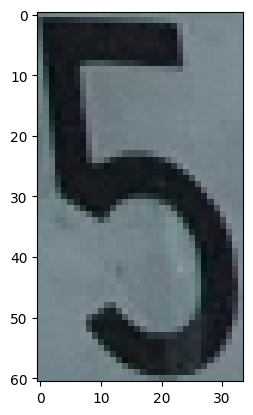

In [76]:
crp_dig = image[y:y + h, x:x + w]

plt.imshow(crp_dig)

# img size
h, w, _ = crp_dig.shape
print(h, w)



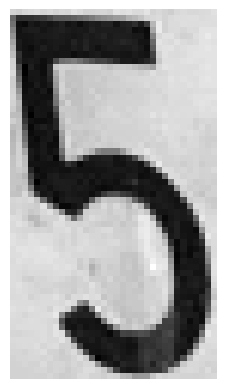

In [77]:
# Aumentar el contraste en una imagen en escala de grises usando cv2.normalize()
normalized_image = cv2.normalize(crp_dig, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# pasar a escalas de grises
normalized_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen con mayor contraste
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.show()

## REDIMENSIONAR Y UNIFICAR TAMANY

In [38]:
from PIL import Image
import os

def resize_with_padding(image, size=(34, 80)):
    # Obtenir dimensions originals
    h_orig, w_orig = image.shape[:2]
    aspect_ratio = w_orig / h_orig
    
    # Calcular la mida nova mantenint la relació d'aspecte
    if aspect_ratio > (size[0] / size[1]):  # Imatge més ampla que la mida desitjada
        new_w = size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Imatge més alta que la mida desitjada
        new_h = size[1]
        new_w = int(new_h * aspect_ratio)

    # Redimensionar la imatge
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

    # Crear una nova imatge en blanc (farcit) en format color
    final_img = np.ones((size[1], size[0], 3), dtype=np.uint8) * 255  # Fons blanc

    # Calcular la posició per centrar la imatge redimensionada
    x_offset = (size[0] - new_w) // 2
    y_offset = (size[1] - new_h) // 2

    # Si resized_img és una imatge en escala de grisos (2D), la convertim a 3 canals (RGB)
    if len(resized_img.shape) == 2:  # Si és 2D, és una imatge en escala de grisos
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2BGR)  # Convertir a RGB

    # Enganxar la imatge redimensionada en la nova imatge
    final_img[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img
    
    return final_img

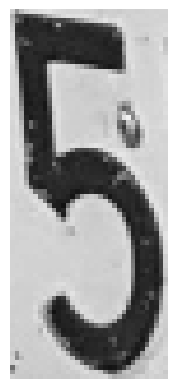

In [40]:
f_image = resize_with_padding(normalized_image)

plt.imshow(f_image)
plt.axis('off')  # Ocultar los ejes
plt.show()